# Oxford Pets - Multiclass Classification

## Modules

In [1]:
import sys
sys.path.insert(0, '../../common') ## '../..' for parent-parent directory

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

import os
import albumentations as A
from functools import partial

import argparse
import numpy as np
import random

from oxford_pets import get_paths_labels, get_bbox, get_image_path
import tf_trainer as my

os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

## Parameters

In [2]:
manual_seed = 42
random.seed(manual_seed)
np.random.seed(manual_seed)
tf.random.set_seed(manual_seed)

In [3]:
image_shape = (128, 128, 3)
# image_shape = (224, 224, 3)
batch_size = 64

## Data Set

## Data Loader

In [4]:
@tf.function
def load_data(image_path, bbox, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, bbox, label


def augmenation(image, bbox, label, training, img_size):
    if training:
        transform = A.Compose([
            A.Resize(height=img_size[0], width=img_size[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5, shift_limit=0.05, 
                                scale_limit=0.05, rotate_limit=15,),
            # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))
    else:
        transform = A.Compose([
            A.Resize(height=img_size[0], width=img_size[1]),
            # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

    transformed = transform(image=image, bboxes=[bbox], labels=[label])
    image = transformed['image']
    bbox = transformed['bboxes'][0]   # tuple
    label = transformed['labels'][0]  # not tuple
    bbox_label = bbox + (label,)      # concatenation of tuples

    image = tf.cast(image, tf.float32)
    bbox_label = tf.cast(bbox_label, tf.float32)
    return image, bbox_label


@tf.function
def preprocess(image, bbox, label, training, img_size):
    image, bbox_label = tf.numpy_function(augmenation, 
                            inp=[image, bbox, label, training, img_size], 
                            Tout=[tf.float32, tf.float32])
    return image, bbox_label


def get_dataloader(image_paths, bboxes, labels, batch_size, training, img_size):
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    dataloader = tf.data.Dataset.from_tensor_slices((image_paths, bboxes, labels))
    dataloader = dataloader.map(load_data, num_parallel_calls=AUTOTUNE)
    dataloader = dataloader.map(
                    partial(preprocess, training=training, img_size=img_size),
                    num_parallel_calls=AUTOTUNE)
    if training:
        dataloader = dataloader.shuffle(1000)

    dataloader = dataloader.batch(batch_size).prefetch(AUTOTUNE)
    return dataloader

In [5]:
data_dir = "/mnt/f/deep_learning/datasets/oxford_pets_783M/"
image_dir = os.path.join(data_dir, "images")
bbox_dir = os.path.join(data_dir, "annotations", "xmls")

train_data, valid_data, class_names = get_paths_labels(
        bbox_dir, file_type="*.xml", n_classes=37, fold=0)
train_bbox_paths, train_labels = train_data
valid_bbox_paths, valid_labels = valid_data

train_bboxes = [get_bbox(path) for path in train_bbox_paths]
valid_bboxes = [get_bbox(path) for path in valid_bbox_paths]

train_image_paths = [get_image_path(path, image_dir) for path in train_bbox_paths]
valid_image_paths = [get_image_path(path, image_dir) for path in valid_bbox_paths]

train_loader = get_dataloader(train_image_paths, train_bboxes, train_labels,
                    batch_size=batch_size, training=True, img_size=image_shape[:2])
valid_loader = get_dataloader(valid_image_paths, valid_bboxes, valid_labels,
                    batch_size=batch_size, training=False, img_size=image_shape[:2])

In [6]:
x, y = next(iter(train_loader))
images = x.numpy()
bboxes_labels = y.numpy()
bboxes, labels = bboxes_labels[:, :4], bboxes_labels[:, 4:]

images.shape, images.min(), images.max()

((64, 128, 128, 3), 0.0, 255.0)

## Modeling

In [7]:
from  tensorflow.keras.applications import mobilenet_v2
from  tensorflow.keras.applications import efficientnet_v2

def get_model(input_shape, freezed=False):
    inputs = keras.Input(input_shape)
    # base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model = efficientnet_v2.EfficientNetV2S(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = not freezed

    # x = mobilenet_v2.preprocess_input(inputs)

    x = efficientnet_v2.preprocess_input(inputs)
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(4, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)

In [8]:
@tf.function
def iou(box1, box2):
    x1, y1, w1, h1 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    x2, y2, w2, h2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    inter_w = tf.minimum(x1 + w1/2, x2 + w2/2) - tf.maximum(x1 - w1/2, x2 - w2/2)
    inter_h = tf.minimum(y1 + h1/2, y2 + h2/2) - tf.maximum(y1 - h1/2, y2 - h2/2)
    intersection = tf.maximum(inter_w, 0.)*tf.maximum(inter_h, 0.)
    union = w1*h1 + w2*h2 - intersection
    return tf.reduce_mean(intersection / union)

@tf.function
def mse_loss(y_true, y_pred):
    y_true, y_pred = y_true[:, :4], y_pred[:, :4]
    loss_fn = keras.losses.MeanSquaredError()
    return loss_fn(y_true, y_pred)

## Training

In [9]:
# %%time
# from tf_trainer import TrainerWithEarlyStopping
# from utils import plot_progress

# model = get_model(input_shape=image_shape, freezed=True)
# optimizer = keras.optimizers.Adam()
# loss_fn = mse_loss
# metrics = {'iou': iou}

# clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
# hist = clf.fit(train_loader, n_epochs=5, valid_loader=valid_loader)

# plot_progress(hist)

Epoch[  1/100] loss=0.0173, iou=0.3922 | val_loss=0.0087, val_iou=0.4912 (1)                        
Epoch[  2/100] loss=0.0076, iou=0.5398 | val_loss=0.0048, val_iou=0.6094 (1)                        
Epoch[  3/100] loss=0.0054, iou=0.5997 | val_loss=0.0044, val_iou=0.6177 (1)                        
Epoch[  4/100] loss=0.0047, iou=0.6249 | val_loss=0.0046, val_iou=0.6289 (2)                        
Epoch[  5/100] loss=0.0038, iou=0.6510 | val_loss=0.0034, val_iou=0.6737 (1)                        
Epoch[  6/100] loss=0.0041, iou=0.6554 | val_loss=0.0035, val_iou=0.6590 (2)                        
Epoch[  7/100] loss=0.0032, iou=0.6687 | val_loss=0.0032, val_iou=0.6885 (1)                        
Epoch[  8/100] loss=0.0031, iou=0.6925 | val_loss=0.0030, val_iou=0.7136 (1)                        
Epoch[  9/100] loss=0.0032, iou=0.6878 | val_loss=0.0028, val_iou=0.6997 (1)                        
Epoch[ 10/100] loss=0.0026, iou=0.6996 | val_loss=0.0029, val_iou=0.7065 (2)               

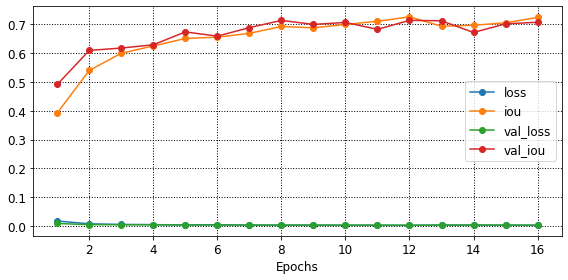

CPU times: user 9min 9s, sys: 2min 28s, total: 11min 37s
Wall time: 5min 25s


In [10]:
%%time
from tf_trainer import TrainerWithEarlyStopping
from utils import plot_progress

model = get_model(input_shape=image_shape, freezed=False)
optimizer = keras.optimizers.Adam()
loss_fn = mse_loss
metrics = {'iou': iou}

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
hist = clf.fit(train_loader, n_epochs=100, valid_loader=valid_loader)

plot_progress(hist)

## Inference

>> Ground Truth:


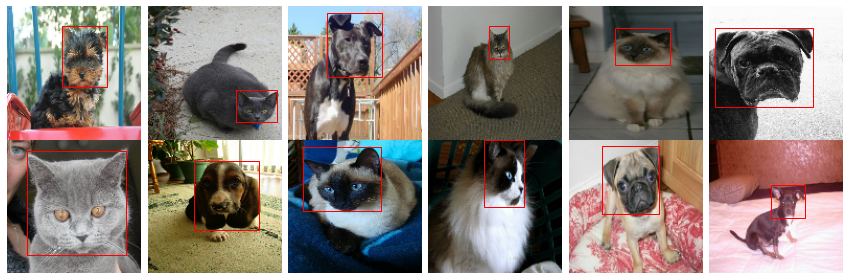

>> Predictions:


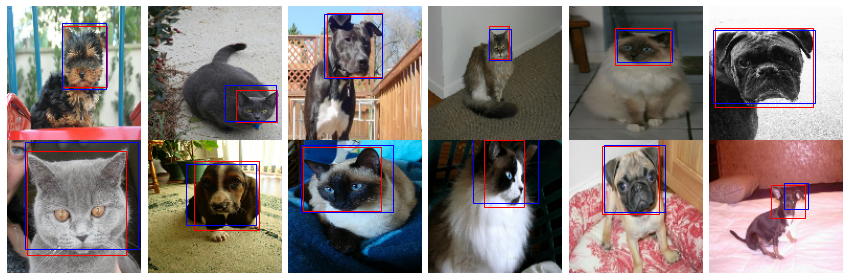

In [11]:
from utils import show_images

images, bboxes_labels = next(iter(valid_loader))
preds = model.predict(images, verbose=0)

images = images.numpy().astype(int)
bboxes_labels = bboxes_labels.numpy()
bboxes, labels = bboxes_labels[:, :4], bboxes_labels[:, 4:]

n_samples = 12
print(f">> Ground Truth:")
show_images(images[:n_samples], 
            bboxes=bboxes[:n_samples], n_cols=6)

print(f">> Predictions:")
show_images(images[:n_samples], 
            bboxes=bboxes[:n_samples], 
            bboxes2=preds[:n_samples], bbox_color2='b', n_cols=6)